In this notebook, we try to create a panorama with opencv-python

In [1]:
# Import necessary packages
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
# Read images
img1 = cv.imread('../../images/panorama/home0.jpg',0)
img2 = cv.imread('../../images/panorama/home1.jpg',0)

# Detection by SIFT
sift = cv.SIFT_create()

print('Start detecting..',end='')
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
print('Done')

Start detecting..Done


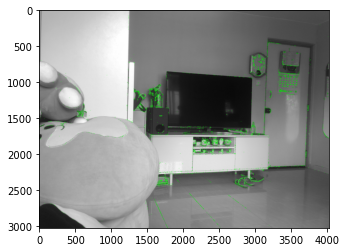

In [3]:
# Plot features of home1
im_fea = cv.drawKeypoints(img2,kp2,None,(0,255,0))
plt.imshow(im_fea)
plt.show()

In [4]:
# Matching

# Set params
MIN_MATCH_COUNT = 10
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv.FlannBasedMatcher(index_params, search_params)

print('Start matching..',end='')
matches = flann.knnMatch(des1,des2,k=2)
print('Done')

Start matching..Done


In [5]:
# Store good matches by Lowe's ratio test
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [6]:
# Find homography if we have enough matches, otherewise show a message
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h],[w,h],[w,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)

    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

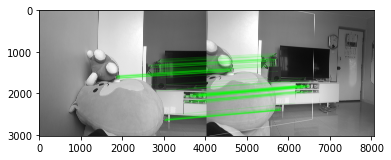

In [7]:
# Plotting matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                singlePointColor = None,
                matchesMask = matchesMask, # draw only inliers
                flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray')
plt.show()

In [8]:
# Image stitching

# Here we assume both images are taken from same device (or simply having same resolutions)
pt_list = np.concatenate((pts,dst),axis=0)

[x_min, y_min] = np.int32(pt_list.min(axis=0).ravel() - 0.5) # Select minimum corner
[x_max, y_max] = np.int32(pt_list.max(axis=0).ravel() + 0.5)

translate_dist = [-x_min,-y_min]

H_translation = np.array([[1,0,-x_min],[0,1,-y_min],[0,0,1]])

# Warp img1
img_output = cv.warpPerspective(img1,H_translation@M,(x_max-x_min,y_max-y_min))

# Append img2
img_output[-y_min:h-y_min,-x_min:w-x_min] = img2

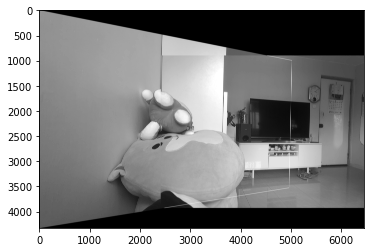

In [9]:
plt.gray()
plt.imshow(img_output)
plt.show()

In [10]:
cv.imwrite('../../images/panorama/home_panorama.jpg',img_output)

True